In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

## Model Architecture

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool3d(2)

    def forward(self, x):
        skip_connection = self.conv_block(x)
        x = self.pool(skip_connection)
        return skip_connection, x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(skip_channels + out_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.up(x)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv_block(x)
        return x

class UNet3D(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet3D, self).__init__()
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder1 = DecoderBlock(1024, 512, 512)
        self.decoder2 = DecoderBlock(512, 256, 256)
        self.decoder3 = DecoderBlock(256, 128, 128)
        self.decoder4 = DecoderBlock(128, 64, 64)

        self.final_conv = nn.Conv3d(64, n_classes, kernel_size=1)
        self.activation = nn.Sigmoid() if n_classes == 1 else nn.Softmax(dim=1)

    def forward(self, x):
        s1, p1 = self.encoder1(x)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)

        b = self.bottleneck(p4)

        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        out = self.final_conv(d4)
        return self.activation(out)

# Example usage
model = UNet3D(in_channels=1, n_classes=2) #Mask or no mask


## Loss Function

In [3]:
# Dice Coefficient and Dice Loss
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1.0
    flat_y_true = y_true.view(-1)
    flat_y_pred = y_pred.view(-1)
    intersection = (flat_y_true * flat_y_pred).sum()
    return (2. * intersection + smoothing_factor) / (flat_y_true.sum() + flat_y_pred.sum() + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, class_weights):
        super(DiceLoss, self).__init__()
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)

    def forward(self, y_pred, y_true):
        y_true = F.one_hot(y_true, num_classes=len(self.class_weights)).permute(0, 3, 1, 2).float()
        y_pred = F.softmax(y_pred, dim=1)
        intersection = torch.sum(y_pred * y_true, dim=(2, 3))
        cardinality = torch.sum(y_pred + y_true, dim=(2, 3))
        dice_score = 2. * intersection / (cardinality + 1e-7)
        return (1 - dice_score) * self.class_weights.to(y_pred.device)

class CategoricalFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(CategoricalFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        y_true = F.one_hot(y_true, num_classes=y_pred.size(1)).permute(0, 3, 1, 2).float()
        y_pred = F.softmax(y_pred, dim=1)
        ce_loss = F.cross_entropy(y_pred, y_true, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
        self.focal_loss = CategoricalFocalLoss()

    def forward(self, y_pred, y_true):
        return self.dice_loss(y_pred, y_true) + self.focal_loss(y_pred, y_true)

# Example usage
combined_loss = CombinedLoss()

# Example input (random)
#y_pred = torch.randn(10, 4, 256, 256)  # Example prediction
#y_true = torch.randint(0, 4, (10, 256, 256))  # Example ground truth

# Calculate loss
#loss = combined_loss(y_pred, y_true)
#print(loss)

## Parameters of the model

In [5]:
# Model Parameters
patch_size = (64, 64, 64)
channels = 1
LR = 0.0001
encoder_weights = 'imagenet'

# Load VGG16 backbone with pretrained weights
BACKBONE = 'vgg16'
encoder = models.vgg16(weights=True if encoder_weights == 'imagenet' else False)

# Activation Function
activation = nn.Sigmoid() #maybe change to Softmax


c:\Users\benysar\Desktop\Github\stroke-occlusion\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Metrics

In [6]:
def iou_score(output, target, smooth=1e-6):
    """
    Compute the IoU score.
    output: Tensor of predictions (N, C, H, W)
    target: Tensor of ground truth (N, H, W) with class indices
    """
    with torch.no_grad():
        # Convert targets to one-hot encoding
        target_one_hot = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()

        # Apply sigmoid or softmax depending on your output
        output_probs = torch.sigmoid(output)  # use torch.softmax for multi-class

        # Calculate intersection and union
        intersection = torch.sum(output_probs * target_one_hot, dim=(2, 3))
        total = torch.sum(output_probs + target_one_hot, dim=(2, 3))
        union = total - intersection

        # Compute IoU and average over batch
        IoU = (intersection + smooth) / (union + smooth)
        return IoU.mean()

def f_score(output, target, beta=1, threshold=0.5, smooth=1e-6):
    """
    Compute the F-score, also known as F1 score or F-measure.
    output: Tensor of predictions (N, C, H, W)
    target: Tensor of ground truth (N, H, W) with class indices
    beta: Beta parameter. beta > 1 gives more weight to recall, beta < 1 to precision.
    threshold: Threshold for converting probabilities to binary (0/1) predictions
    """
    with torch.no_grad():
        # one-hot encoding
        target_one_hot = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()
        output_probs = torch.sigmoid(output)  

        # binarize predictions and targets
        output_bin = (output_probs > threshold).float()
        target_bin = target_one_hot

        tp = torch.sum(target_bin * output_bin, dim=(2, 3))
        fp = torch.sum(output_bin, dim=(2, 3)) - tp
        fn = torch.sum(target_bin, dim=(2, 3)) - tp

        precision = tp / (tp + fp + smooth)
        recall = tp / (tp + fn + smooth)

        fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + smooth)
        return fscore.mean()


In [7]:
optimizer = Adam(model.parameters(), lr=LR)
print(model)

UNet3D(
  (encoder1): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): EncoderBlock(
    (conv_block): ConvBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(128, eps=1e-

## Preprocessing for inputs model

In [8]:
import h5py
import numpy as np
from patchify import patchify
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import os

# Function to apply preprocessing to a batch of images
def preprocess_batch(batch, preprocess_input):
    preprocessed = []
    for img in batch:
        img_pil = Image.fromarray(img)
        img_preprocessed = preprocess_input(img_pil)
        preprocessed.append(img_preprocessed)
    return torch.stack(preprocessed)

# Define the preprocessing steps
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
gray_mean = sum(imagenet_mean) / len(imagenet_mean)
gray_std = sum(imagenet_std) / len(imagenet_std)

preprocess_input = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[gray_mean], std=[gray_std]),
])


### Loading images and patching them

In [9]:
import os
import h5py
import numpy as np
from patchify import patchify, unpatchify
import pickle

image_dir = 'E:/data/SWI/transformed_images/'
mask_dir = 'E:/data/MASK/transformed_images/'
mask_filenames = {filename[:22]: filename for filename in os.listdir(mask_dir) if filename.endswith('.h5')}

patch_size = (64, 64, 64)  # Define your patch size here

image_patches = []
label_patches = [] 

for filename in os.listdir(image_dir):
    if filename.endswith('.h5'):
        base_filename = filename[:22]
        if base_filename in mask_filenames:
            image_file = os.path.join(image_dir, filename)
            mask_file = os.path.join(mask_dir, mask_filenames[base_filename])

            try:
                with h5py.File(image_file, 'r') as h5f:
                    image_dataset = h5f['image'][:]
                
                with h5py.File(mask_file, 'r') as mask_h5f:
                    mask_dataset = mask_h5f['image'][:]

                for image, label in zip(image_dataset, mask_dataset):
                    image_patches.extend(patchify(image, patch_size, step=(64, 64, 64)))
                    label_patches.extend(patchify(label, patch_size,  step=(64, 64, 64)))
            
            except Exception as e:
                print(f"Error processing {image_file} and {mask_file}: {str(e)}")


In [10]:
chunk_size = 100

# Save the image patches 
with open('E:/data/image_patches.pkl', 'wb') as image_patch_file:
    for i in range(0, len(image_patches), chunk_size):
        chunk = image_patches[i:i+chunk_size]
        pickle.dump(chunk, image_patch_file)

# Save the label patches 
with open('E:/data/label_patches.pkl', 'wb') as label_patch_file:
    for i in range(0, len(label_patches), chunk_size):
        chunk = label_patches[i:i+chunk_size]
        pickle.dump(chunk, label_patch_file)

In [11]:
image_patches[0].shape

(4, 1, 64, 64, 64)

In [12]:
from sklearn.model_selection import train_test_split

# Split the image and label patches into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    image_patches, label_patches, test_size=0.2, random_state=42)


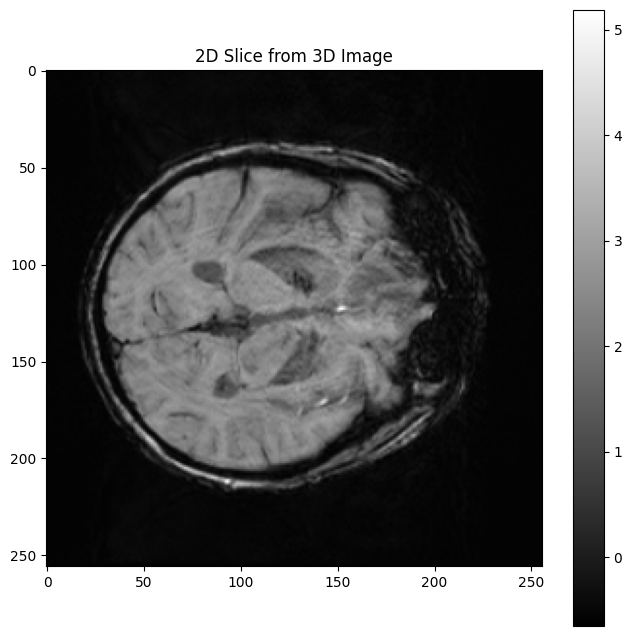

In [122]:
import matplotlib.pyplot as plt
import numpy as np

z_slice = 32  # Middle slice in the z-axis
plt.figure(figsize=(8, 8))
plt.imshow(image_dataset[0, :, :, z_slice], cmap='gray')
plt.title('2D Slice from 3D Image')
plt.colorbar()
plt.show()

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Check number of samples
print(f"Number of training samples: {len(X_train)}")  # Expecting around 1622 => 4*507*0.8

# Check shape of samples
print(f"Shape of each training sample: {X_train[0].shape}")  # Expecting (4, 1, 64, 64, 64) => (number of patches it, 1, 64, 64, 64)

Number of training samples: 1622
Shape of each training sample: (4, 1, 64, 64, 64)


### Preprocessing + split

In [121]:
# Convert to PyTorch tensors
X_train_prep = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test_prep = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_prep, y_train)
test_dataset = TensorDataset(X_test_prep, y_test)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

C:\Windows\Temp\ipykernel_26988\3268389854.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_train_prep = torch.tensor(X_train, dtype=torch.float32)
